In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from scipy.signal import butter

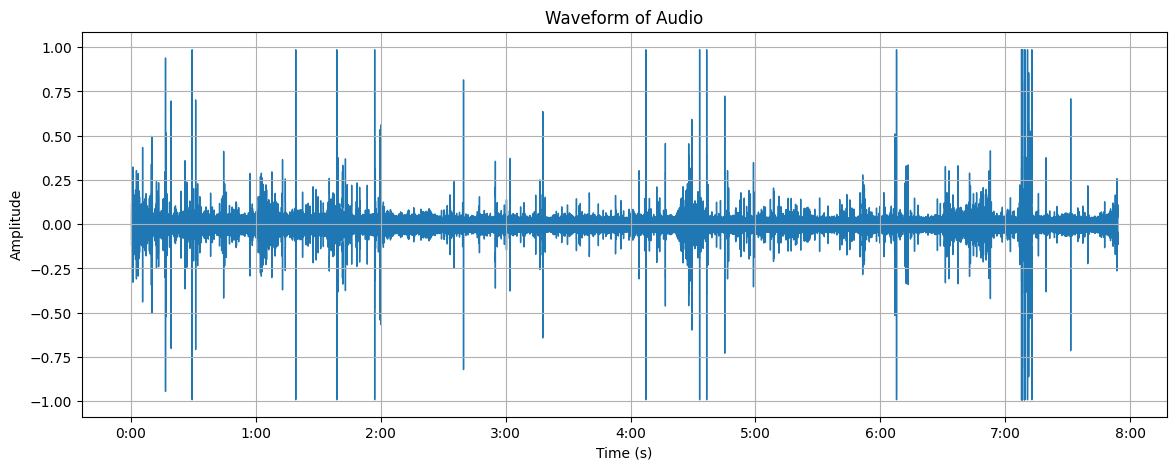

In [25]:
# Load the audio file
filename = '../data/1_Cut_Clean.wav'
y, sr = librosa.load(filename, sr=None)

# Display the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

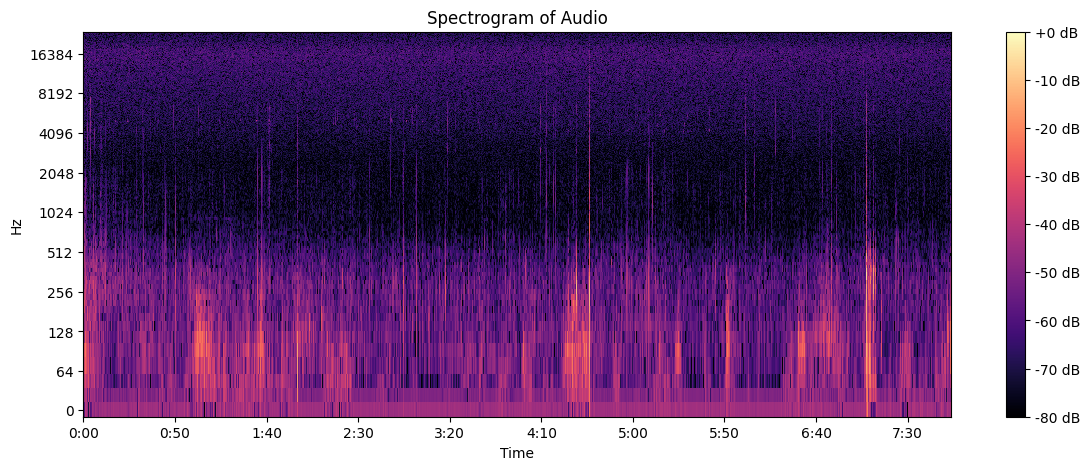

In [26]:
# Display the spectrogram
plt.figure(figsize=(14, 5))
plt.title('Spectrogram of Audio')
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [27]:
# Separate the audio into segments of 3 seconds
segment_duration = 2  # seconds
segment_samples = segment_duration * sr
segments = []
for start in range(0, len(y), segment_samples):
    end = start + segment_samples
    if end <= len(y):
        segments.append(y[start:end])

# Convert segments to a DataFrame
segments_df = pd.DataFrame(segments)

# Display the first few segments
print("First few segments of audio:")
print(segments_df.head())


First few segments of audio:
      0         1         2         3         4         5         6      \
0  0.012017 -0.002028  0.026940  0.007144  0.013591  0.012744  0.003965   
1 -0.013591 -0.015165 -0.025911 -0.015377 -0.005358 -0.016860 -0.021159   
2  0.032873  0.033993  0.022733  0.031299  0.041591  0.026850  0.033479   
3 -0.020796 -0.021189 -0.036021 -0.015256 -0.024398 -0.037081 -0.038897   
4 -0.003481 -0.008143  0.013682 -0.022460  0.009444  0.005993 -0.002936   

      7         8         9      ...     95990     95991     95992     95993  \
0  0.016921  0.011775  0.013894  ... -0.022188 -0.017133 -0.002452 -0.007568   
1 -0.002724 -0.015105 -0.021371  ...  0.048462  0.048735  0.018041  0.034235   
2  0.036354  0.022188  0.030875  ...  0.019706  0.011049 -0.000242  0.002058   
3 -0.055455 -0.038504 -0.051671  ...  0.018374  0.002301 -0.012774 -0.003390   
4 -0.004631 -0.000666  0.004692  ... -0.017042 -0.008324  0.006447 -0.001786   

      95994     95995     95996     959

In [28]:
# Feature extraction 

def extract_features(segment):
    # Extract features from the audio segment
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)

    # Combine features into a single array
    features = np.hstack([np.mean(mfccs, axis=1),
                           np.mean(spectral_contrast, axis=1)])
    return features

# Extract features for each segment
features_list = []
for segment in segments:
    features = extract_features(segment)
    features_list.append(features)

# Convert features to a DataFrame
features_df = pd.DataFrame(features_list, columns=['mfcc' + str(i) for i in range(1, 14)] +
                              ['spectral_contrast' + str(i) for i in range(1, 8)])

# Display the first few features
print("First few features extracted:")
print(features_df.head())

First few features extracted:
        mfcc1      mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  \
0 -267.673615  46.703194  64.031761  32.928478  15.552228  16.167280   
1 -274.380524  34.747871  58.802704  40.761314  21.927851  17.284861   
2 -276.237610  38.093884  63.287495  36.601677  16.700342  13.582073   
3 -289.931732  27.988173  63.139694  35.528793  17.572987  15.821967   
4 -273.832397  27.782745  44.177635  27.671093  12.424808   8.713869   

       mfcc7      mfcc8      mfcc9    mfcc10    mfcc11    mfcc12    mfcc13  \
0  10.702347  13.283422  -1.952884  4.061056 -1.126443  5.826004 -1.758799   
1  11.635441  10.734484  -5.457870  2.348419 -2.514964  4.339378 -2.794294   
2   6.058228   6.864609  -7.231373  2.420854 -3.600127  3.089423 -1.368687   
3   6.616104   7.585361  -8.080308 -1.173632 -4.766653  2.585836 -5.079667   
4   1.676748   2.392475 -11.878558 -1.904354 -3.467638  4.823791 -4.966598   

   spectral_contrast1  spectral_contrast2  spectral_contrast3  \
0  

In [29]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_df_scaled = scaler.fit_transform(features_df)
features_df_scaled = pd.DataFrame(features_df_scaled, columns=features_df.columns)

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_df_scaled)

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['segment'] = segments_df.index



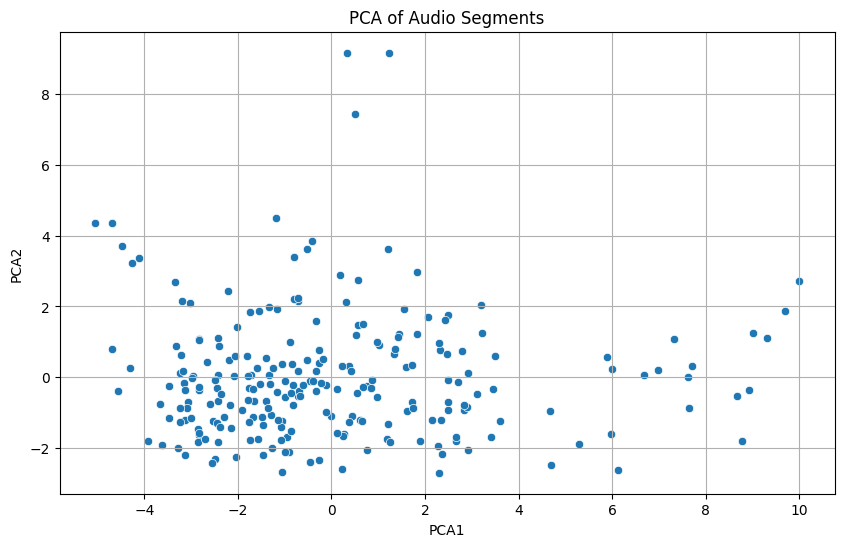

In [30]:
# Plot PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df)
plt.title('PCA of Audio Segments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.show()

In [31]:
# Perform clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df[['PCA1', 'PCA2']])
pca_df['cluster'] = kmeans.labels_

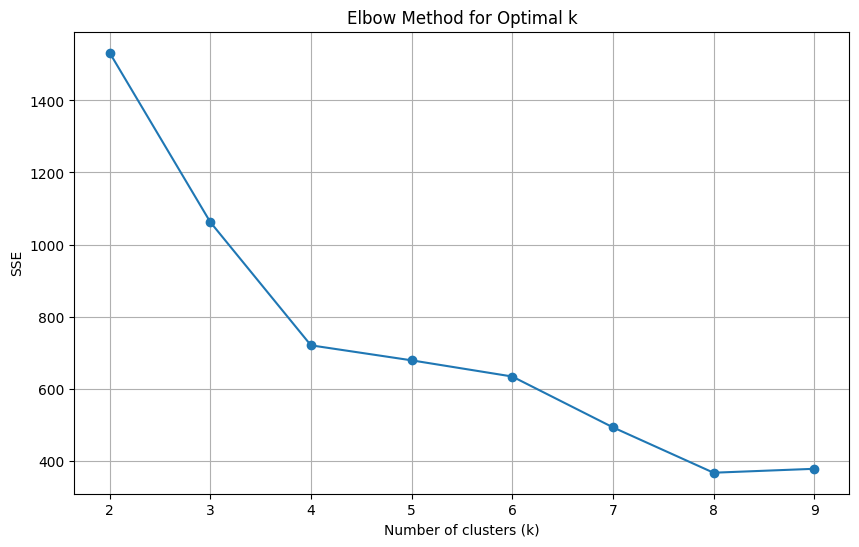

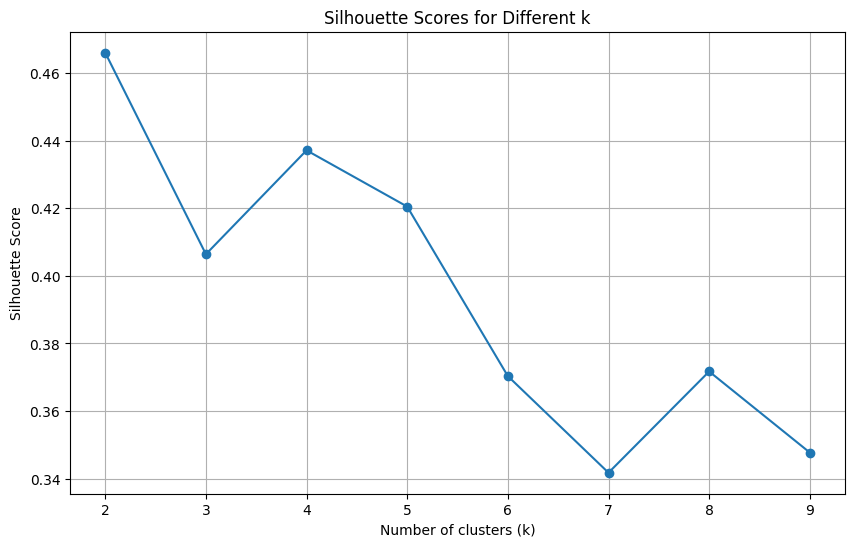

In [32]:
# Find the optimal number of clusters using the elbow method
from sklearn.metrics import silhouette_score

sse = []
silhouette_scores = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df[['PCA1', 'PCA2']])
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_df[['PCA1', 'PCA2']], kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.grid()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

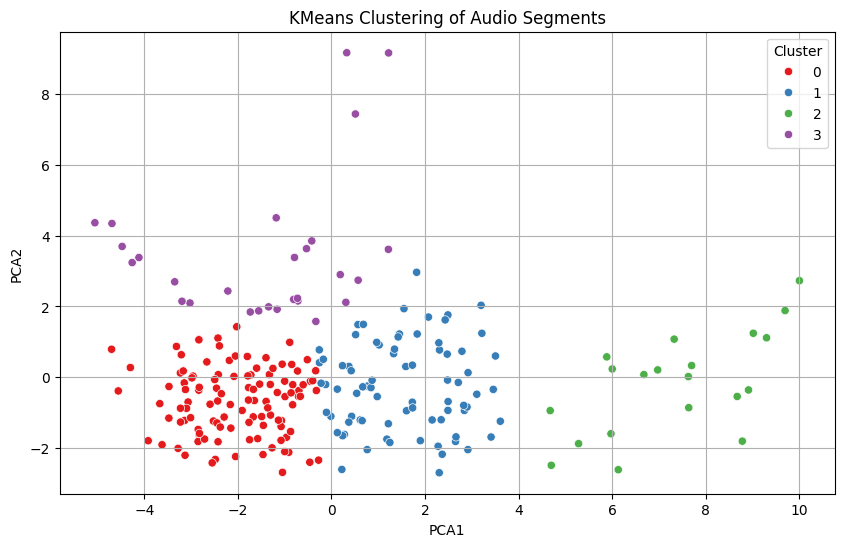

In [33]:
# KMeans clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df[['PCA1', 'PCA2']])
pca_df['cluster'] = kmeans.labels_
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='Set1')
plt.title('KMeans Clustering of Audio Segments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

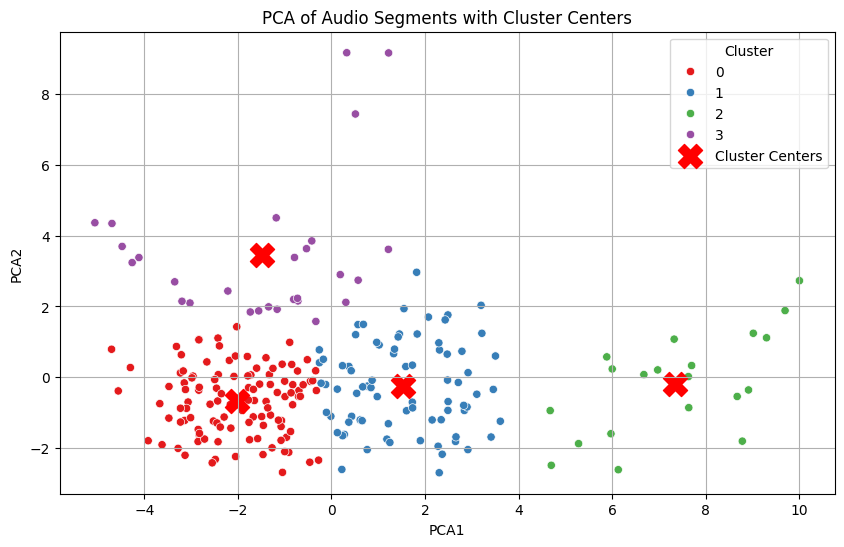

In [34]:
# Plot the cluster centers
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1')
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Cluster Centers')
plt.title('PCA of Audio Segments with Cluster Centers')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [35]:
# Add cluster labels to the original DataFrame
segments_df['cluster'] = pca_df['cluster']

In [36]:
# # Save the segments with cluster labels to a CSV file
# segments_df.to_csv('../data/audio_segments_with_clusters.csv', index=False)

# # Save the PCA result to a CSV file
# pca_df.to_csv('../data/pca_result.csv', index=False)

# # Save the features to a CSV file
# features_df.to_csv('../data/audio_features.csv', index=False)

In [37]:
# # Load the segments with cluster labels
# segments_df = pd.read_csv('../data/audio_segments_with_clusters.csv')

# # Load the PCA result
# pca_df = pd.read_csv('../data/pca_result.csv')

# # Load the features
# features_df = pd.read_csv('../data/audio_features.csv')

/home/dccartagena/projects/under_sound/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


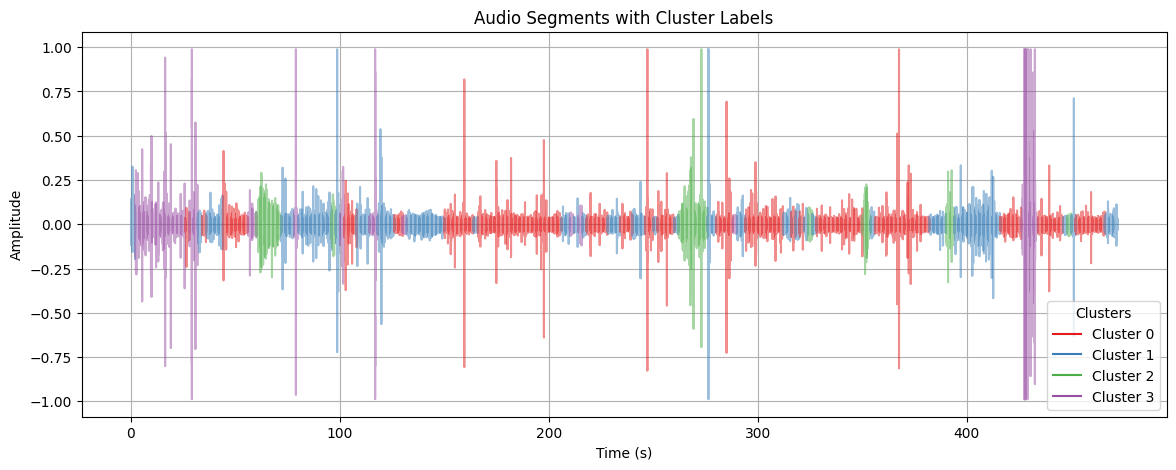

In [38]:
# Plot the audio segments with cluster labels as colors
plt.figure(figsize=(14, 5))
colors = sns.color_palette('Set1', n_colors=4)  

for i, segment in enumerate(segments):
    cluster_label = segments_df.loc[i, 'cluster']
    plt.plot(np.arange(len(segment)) / sr + i * segment_duration, segment, color=colors[cluster_label], alpha=0.5)

# Add a legend for the clusters
for cluster_label in range(4):
    plt.plot([], [], color=colors[cluster_label], label=f'Cluster {cluster_label}')

plt.title('Audio Segments with Cluster Labels')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(title='Clusters')
plt.grid()
plt.show()


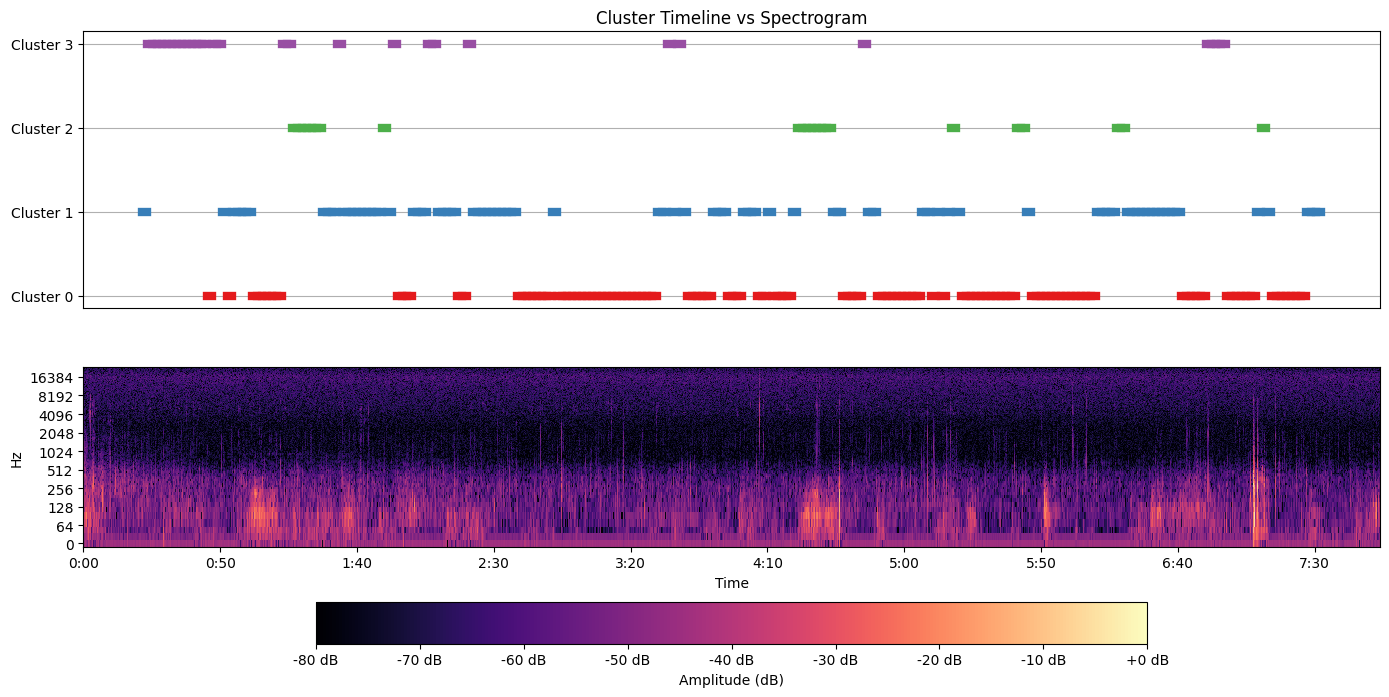

In [ ]:
# Make two subplots: one for the spectrogram of the whole audio and another for a timeline plot of the clusters
plt.figure(figsize=(14, 10))

# Spectrogram plot
plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')

# Move the colorbar to the bottom
cbar = plt.colorbar(img, format='%+2.0f dB', orientation='horizontal', pad=0.2)
cbar.set_label('Amplitude (dB)')

# Get the time limits from the spectrogram for alignment
x_min, x_max = plt.xlim()
total_duration = len(y) / sr  # Total duration in seconds

# Timeline plot of clusters
plt.subplot(2, 1, 1)
plt.title('Cluster Timeline vs Spectrogram')
colors = sns.color_palette('Set1', n_colors=4)
for i, segment in enumerate(segments):
    cluster_label = segments_df.loc[i, 'cluster']
    start_time = i * segment_duration
    end_time = (i + 1) * segment_duration
    plt.plot([start_time, end_time], [cluster_label, cluster_label], color=colors[cluster_label], linewidth=6)

# Set the same x-axis limits for both plots
plt.yticks(range(4), [f'Cluster {i}' for i in range(4)])
plt.grid()
plt.xticks([])  # Remove the x-axis

plt.tight_layout()
plt.show()